In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from NetEmbs import *
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
embs = pd.read_pickle("model/tmps/tmp_dataMarcel.pkl")

In [4]:
embs.head()

,ID,Emb,GroundTruth
0,1,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase
1,3,"[-0.19971998, 0.38667735, 0.02246202, 0.154739...",Sales 21 btw
2,4,"[0.16549358, -0.20079182, 0.38595855, -0.10701...",Cost of Sales
3,5,"[-0.18310927, -0.14398952, -0.0246522, 0.01622...",Fixed Assets
4,6,"[-0.22611028, 0.023601333, 0.11976176, -0.1576...",Tax disbursement


Collections


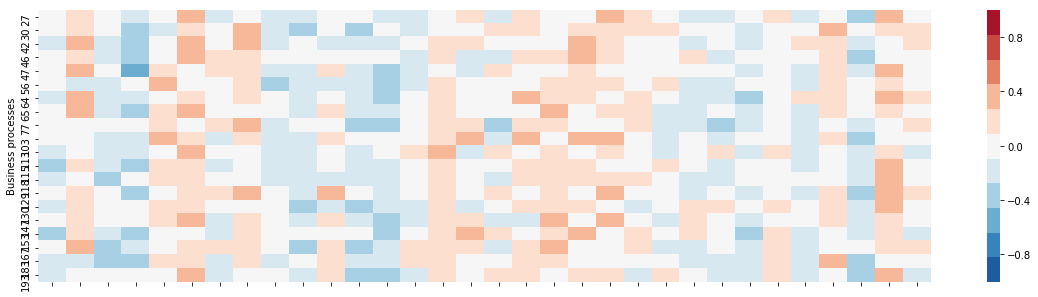

/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Cost of Sales


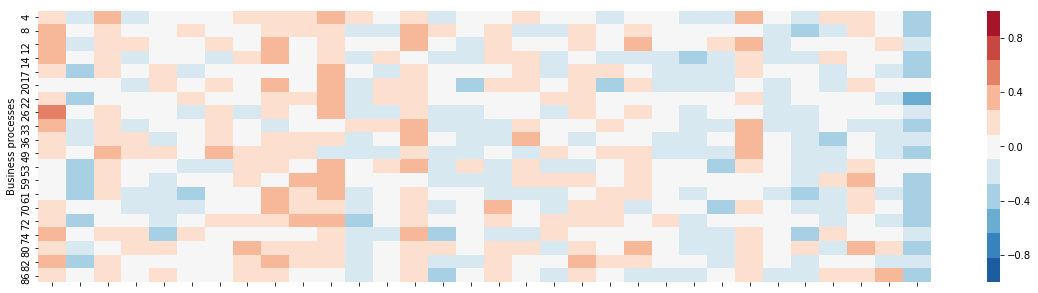

Depreciation


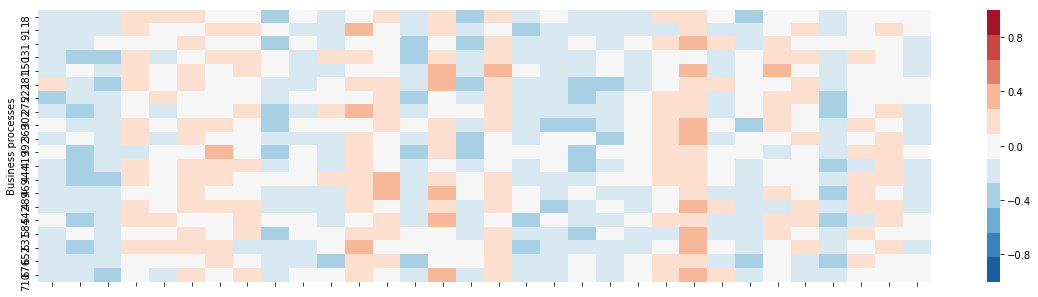

Fixed Assets


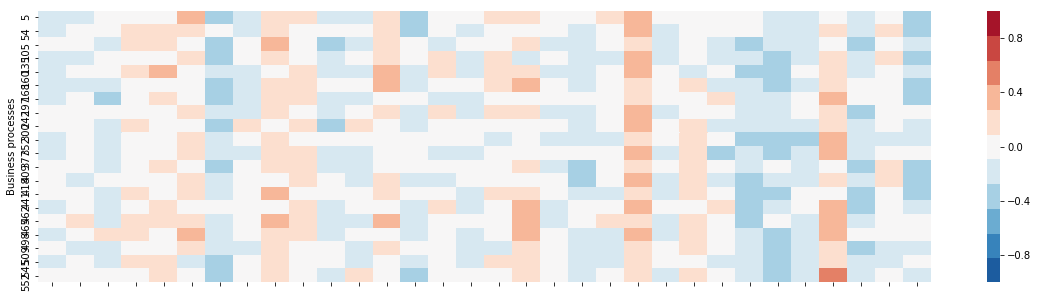

Payroll


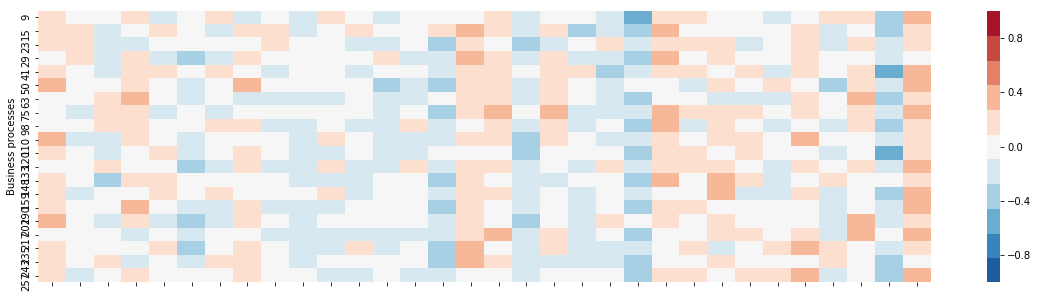

Payroll Disbursement
Not enough samples...
Purchase


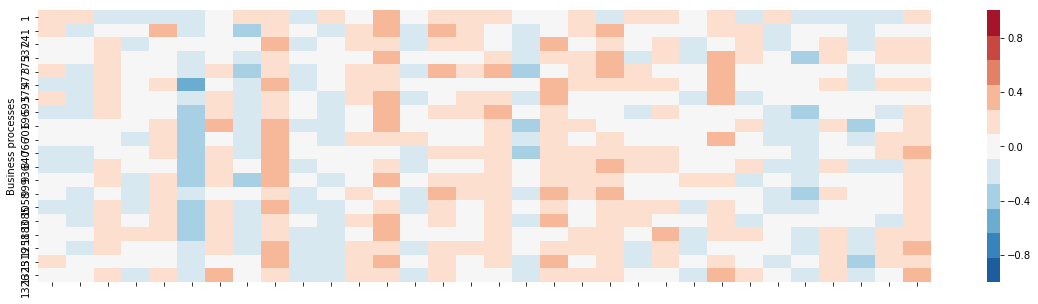

Sales 21 btw


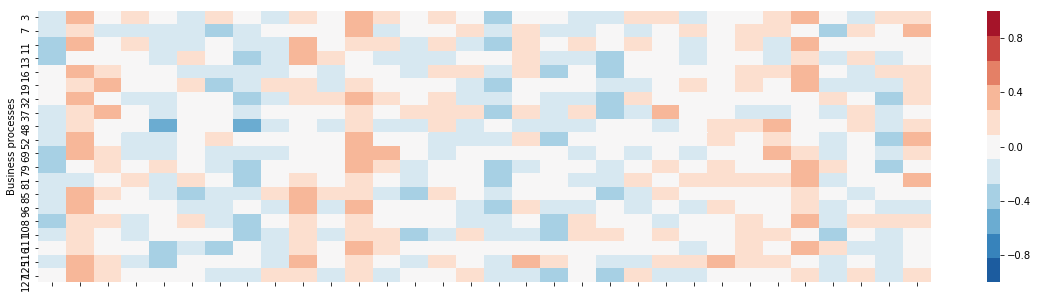

Sales 6 btw


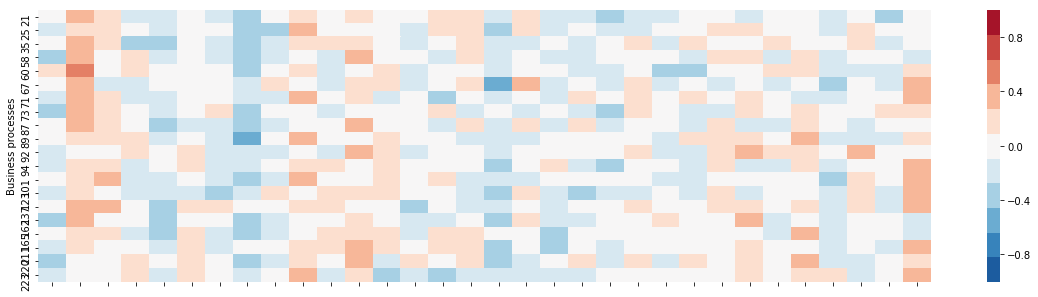

Tax disbursement
Not enough samples...


In [5]:
dims = 20
ns = 11
sm_embs = pd.DataFrame(columns=list(embs)+["Legend"])
for name, group in embs.groupby("GroundTruth"):
    print(name)
    if group.shape[0] > 3:
        plt.figure(figsize=(20, 5))
        sns.heatmap(list(group["Emb"].values[:dims]), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 11))
        frame1 = plt.gca()
        frame1.axes.set_xlabel('')
        frame1.axes.set_ylabel('Business processes')
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels(list(group["ID"].values[:dims]))
        plt.show()
        app = group.head(ns).copy()
#         app["Legend"] = np.array([None, None, group["GroundTruth"].values[0], None, None])
        sm_embs = sm_embs.append(app).append(pd.DataFrame({"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}))
    else:
        print("Not enough samples...")

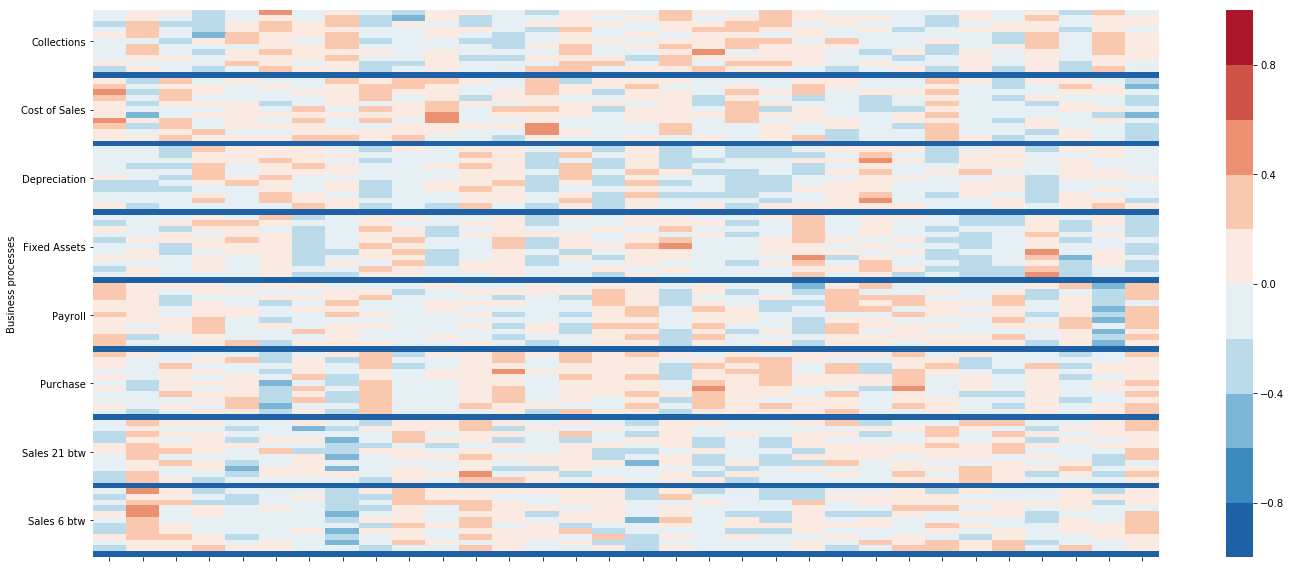

In [9]:
# sm_embs = embs.head(50).sort_values("GroundTruth")
title="vectors_vis_batch128_0905"
import matplotlib.ticker as ticker
plt.figure(figsize=(20, 8))
t_ax = sns.heatmap(list(sm_embs["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
frame1 = plt.gca()
frame1.axes.set_xlabel('')
frame1.axes.set_ylabel('Business processes')
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels(list(sm_embs["GroundTruth"].dropna().unique()), rotation='horizontal')
frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns/2+it*(ns+1) for it in range(8)]))
plt.rc('axes', titlesize=18)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.tight_layout()
plt.savefig("img/" + title, dpi=140, pad_inches=0.01)

In [78]:
def plotVectors(df, title="Vectors"):
    import matplotlib.ticker as ticker
    plt.figure(figsize=(20, 8))
    t_ax = sns.heatmap(list(df["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 10))
    frame1 = plt.gca()
    frame1.axes.set_xlabel('')
    frame1.axes.set_ylabel('Business processes')
    frame1.axes.xaxis.set_ticklabels([])
    ns = np.where(df.GroundTruth.values==None)[0][0]
    frame1.axes.yaxis.set_ticklabels(list(df["GroundTruth"].dropna().unique()), rotation='horizontal')
    frame1.axes.yaxis.set_major_locator(ticker.FixedLocator([ns/2+it*(ns+1) for it in range(8)]))
    plt.rc('axes', titlesize=18)  # fontsize of the x and y titles
    plt.rc('axes', labelsize=18)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
    postfix = "_emb_size"+str(len(df["Emb"].values[0]))+"samples_per_group"+str(ns)
    plt.tight_layout()
    plt.savefig("img/" + title+postfix, dpi=140, pad_inches=0.01)

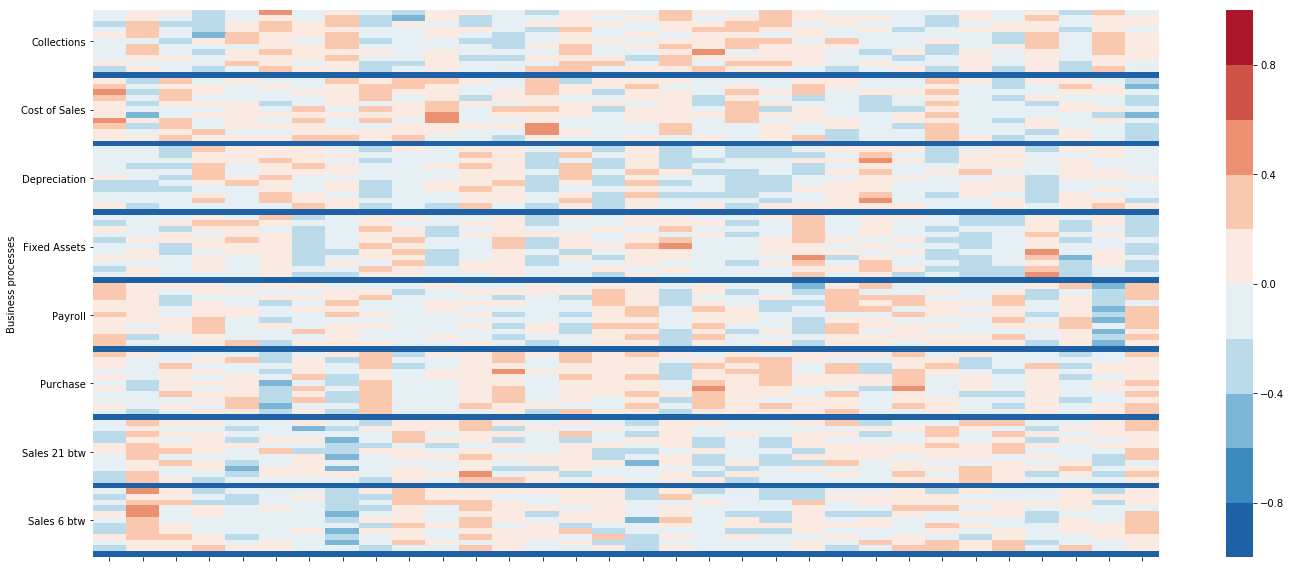

In [6]:
plotVectors(sm_embs)

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


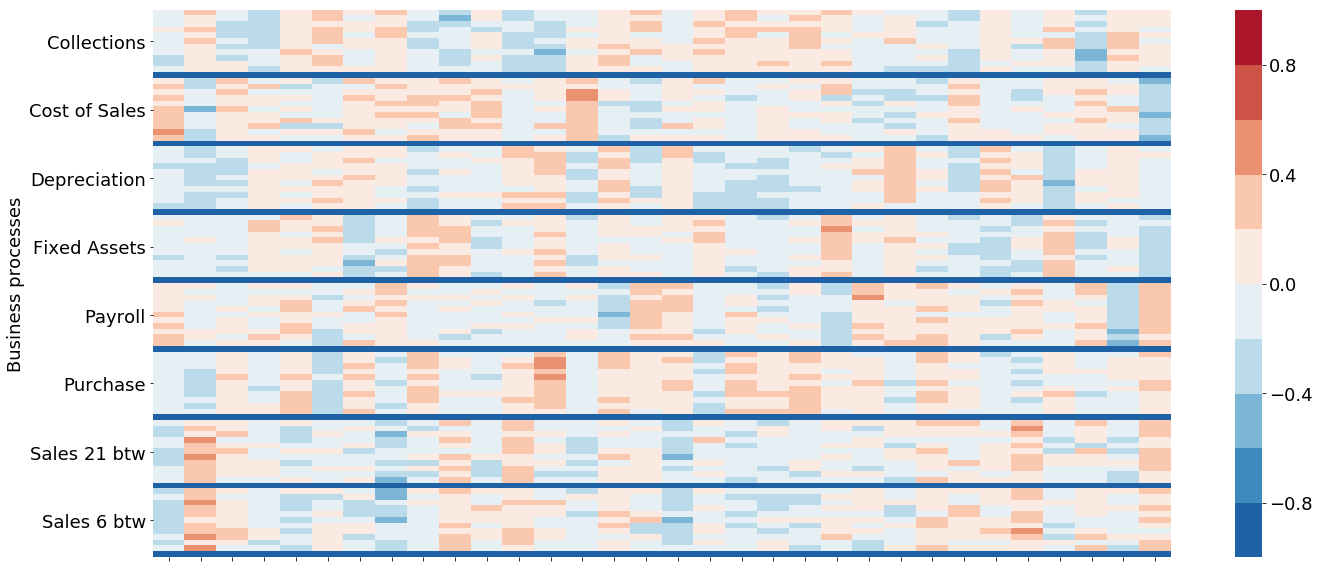

In [26]:
def groupVectors(df, how="median", samples_per_group=11, print_info=False):
    means = dict()
    pretty_vectors = pd.DataFrame(columns=list(df))
    for name, group in df.groupby("GroundTruth"):
        if group.shape[0] > samples_per_group:
            cur_data = group.copy()
            if how=="mean":
                means[name] = np.mean(group["Emb"].values, axis=0)
            elif how=="median":
                means[name]=np.median(group["Emb"].values.tolist(), axis=0)
            elif how=="random":
                means[name]=group["Emb"].values[0]
            cur_data["Similarity"] = cur_data["Emb"].apply(lambda x: 
                                                     cosine_similarity(X=means[name].reshape(1, -1), Y=x.reshape(1, -1)))
            cur_data.sort_values("Similarity", ascending=False, axis=0, inplace=True)
            if print_info:
                print("-----"+name+"-----")
                print("Highest similarity: \n", cur_data.Similarity.head(2), "\nLowest similarity: \n", cur_data.Similarity.tail(2))
            app = cur_data.head(samples_per_group).copy()
            pretty_vectors = pretty_vectors.append(app, sort=True).append(pd.DataFrame(
                {"ID": 0, "Emb": [[-2]*32], "GroundTruth": None}), sort=False)
        else:
            print("For group ", name, " is not enough samples...")
    return pretty_vectors

plotVectors(groupVectors(embs, how="mean"), title="prettyVectorsMean")

For group  Payroll Disbursement  is not enough samples...
For group  Tax disbursement  is not enough samples...


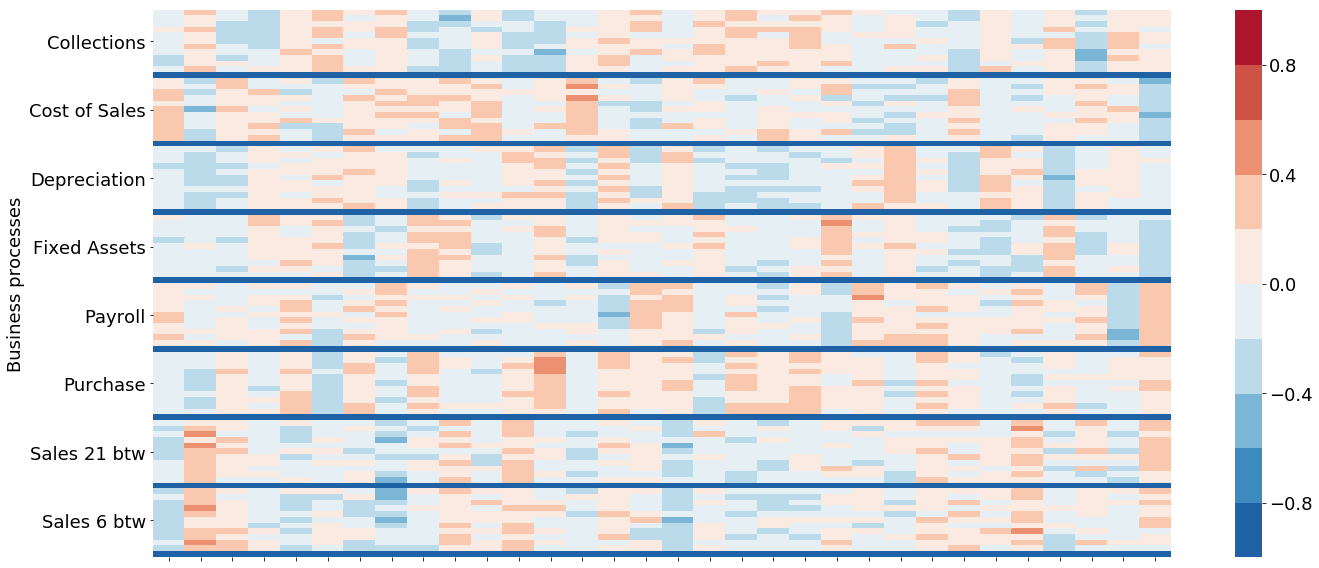

In [10]:
plotVectors(groupVectors(embs, how="median"), title="prettyVectors_median")

## Clustering score

### V-Score

In [11]:
from sklearn.metrics import v_measure_score

In [13]:
cl_data = cl_Agglomerative(embs)

First row of Data: 
 [ 0.20982003  0.16462544 -0.15394551 -0.15415113 -0.18864574 -0.26675463
 -0.08083268  0.10281872  0.23383135 -0.26248536  0.12544529  0.08378573
  0.31039923  0.07646751  0.2392673   0.1405607   0.22745202  0.01175076
 -0.06798675  0.16846085 -0.16137084  0.18566883  0.15066996  0.07055464
  0.22347216 -0.16458535  0.19479321 -0.11342054 -0.10659097 -0.25814846
 -0.11081155  0.20209676]


In [17]:
str_labels = list(cl_data.GroundTruth.unique())
real_labels = dict(zip(str_labels, range(len(str_labels))))
real_labels

{'Purchase': 0,
 'Sales 21 btw': 1,
 'Cost of Sales': 2,
 'Fixed Assets': 3,
 'Tax disbursement': 4,
 'Payroll': 5,
 'Payroll Disbursement': 6,
 'Depreciation': 7,
 'Sales 6 btw': 8,
 'Collections': 9}

In [18]:
cl_data["true_labels"] = cl_data.GroundTruth.apply(lambda x: real_labels[x])

In [19]:
cl_data.head(3)

,ID,Emb,GroundTruth,label,true_labels
0,1,"[0.20982003, 0.16462544, -0.1539455, -0.154151...",Purchase,6,0
1,3,"[-0.19971998, 0.38667735, 0.02246202, 0.154739...",Sales 21 btw,0,1
2,4,"[0.16549358, -0.20079182, 0.38595855, -0.10701...",Cost of Sales,2,2


In [21]:
v_measure_score(cl_data.true_labels.values, cl_data.label.values)

0.9479071032052139